# Pancreas1415 Evaluation Notebook

### Imports and Settings

In [1]:
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)

In [2]:
import numpy as np
import jax
import scanpy as sc
import cellrank as cr
import scvelo as scv

from neural_ot.utils import get_neural_dual_from_ckpt

In [3]:
# set verbosity levels
sc.settings.verbosity = 2
cr.settings.verbosity = 4
scv.settings.verbosity = 3

scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map='viridis')

cr.logging.print_versions()

cellrank==1.5.1+g16069e2 scanpy==1.9.1 anndata==0.8.0 numpy==1.23.1 numba==0.53.1 scipy==1.9.0 pandas==1.3.5 pygpcca==1.0.3 scikit-learn==1.1.2 statsmodels==0.13.2 scvelo==0.2.4 pygam==0.8.0 matplotlib==3.5.2 seaborn==0.11.2


## Get trained model

In [4]:
# params
input_dim = 50
batch_size = 1024
first_quadratic_term = False
first_quadratic = True
ckpt_dir = f"../neural_ot/runs/ckpts/pancreas_1415/makkuva_pretrain_prolif4/best"

In [5]:
# create and load neural dual
neural_dual = get_neural_dual_from_ckpt(
    ckpt_dir=ckpt_dir,
    first_quadratic_term=first_quadratic_term,
    first_quadratic=first_quadratic,
    input_dim=input_dim)

## Get Data

In [6]:
new_adata = sc.read("../neural_ot/data/pancreas/1415_growth_rate.h5ad")

In [7]:
# Prepare for Cellrank
new_adata.obs["clusters"] = new_adata.obs["celltype"]
new_adata = new_adata[:, :50].copy()
new_adata.layers["velocity"] = (neural_dual.transport(new_adata.obsm["X_pca"]) - new_adata.obsm["X_pca"])
new_adata.layers["velocity"] = np.asarray(new_adata.layers["velocity"].copy())
new_adata.layers["pca"] = new_adata.obsm["X_pca"].copy()

## Cellrank

In [8]:
vk = cr.kernels.VelocityKernel(new_adata, xkey="pca")
vk.compute_transition_matrix()

Computing transition matrix using `'deterministic'` model


  0%|          | 0/20519 [00:00<?, ?cell/s]

Using `softmax_scale=6.1645`


  0%|          | 0/20519 [00:00<?, ?cell/s]

    Finish (0:00:05)


VelocityKernel

computing velocity embedding
    finished (0:00:03) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


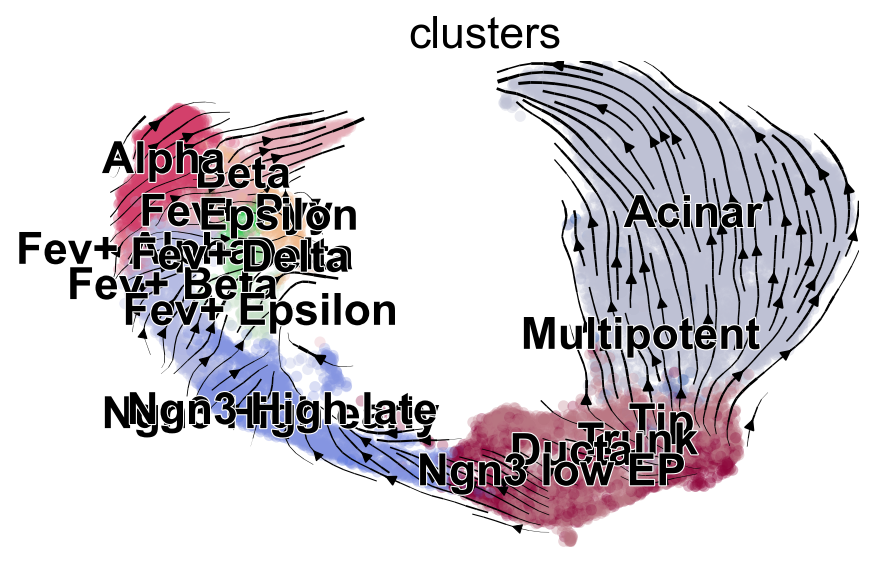

In [9]:
new_adata.uns["velocity_graph"] = vk.transition_matrix
scv.pl.velocity_embedding_stream(new_adata, basis="umap")

In [10]:
g = cr.estimators.GPCCA(vk)

Computing Schur decomposition
Mat Object: 1 MPI processes
  type: seqdense
1.0000000000000087e+00 5.0462117934963384e-11 4.6280281617811676e-05 -1.0957271507339719e-03 -2.5424173135882521e-03 5.6760556577477761e-04 -1.1219902645358878e-02 -9.5081411578400426e-03 -3.2776578087560508e-02 1.2612442098489855e-03 1.5452324443558787e-02 5.1345301388224683e-03 -3.3665869679478107e-02 -2.9505979184971037e-02 -5.2591303719485283e-02 -2.6203788242257067e-02 4.3461697631003972e-02 -5.6002585084351016e-03 -1.6143932887571155e-02 -8.4908382451987872e-03 
0.0000000000000000e+00 9.9999999994048161e-01 -4.9964197802230295e-05 1.2025242240724183e-03 1.9936955134827621e-03 -1.3964795596821792e-03 1.3310901749265157e-02 1.4201602774268239e-02 2.7464859340082085e-02 3.1105117535582054e-04 -1.1749473249984339e-02 -5.2127225685382290e-03 2.5230935362683862e-02 7.6018729797643608e-03 3.6070378596760613e-02 4.8784838315399516e-02 -1.6738958022608233e-02 -2.0770623306068853e-02 2.8106552944088887e-02 6.6578853

Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:01)


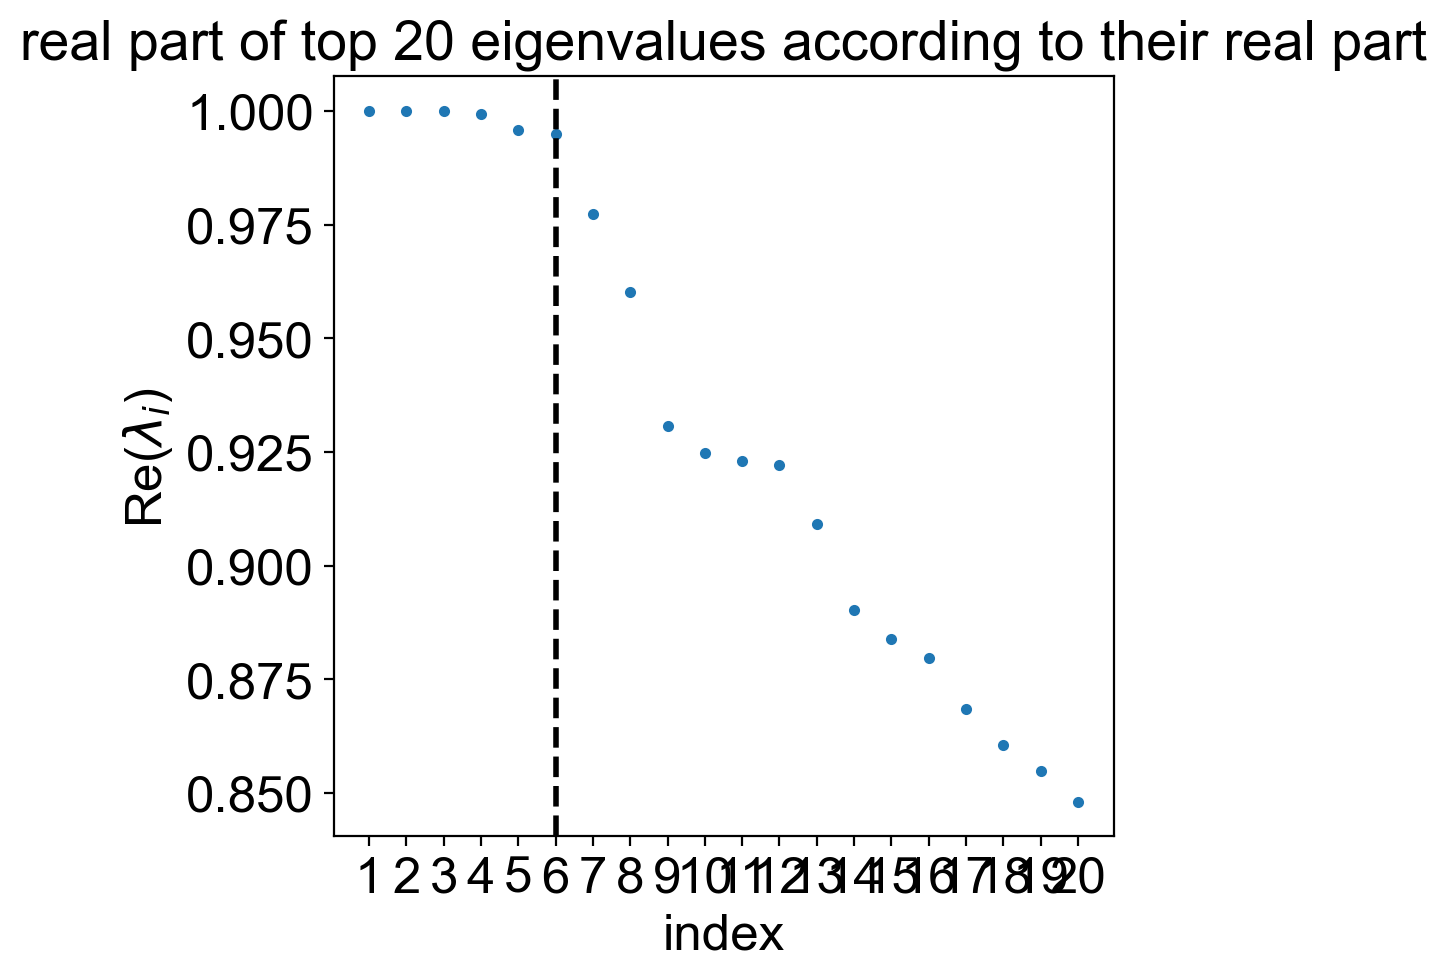

In [11]:
g.compute_schur(n_components=20)
g.plot_spectrum(real_only=True)

In [12]:
g.compute_macrostates(n_states=7, cluster_key="celltype")

Computing `7` macrostates
DEBUG: Setting the macrostates using macrostates memberships
DEBUG: Raising an exception if there are less than `6` cells.
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:03)


DEBUG: Raising an exception if there are less than `6` cells.
Adding `adata.obs['terminal_states']`
       `adata.obs['terminal_states_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


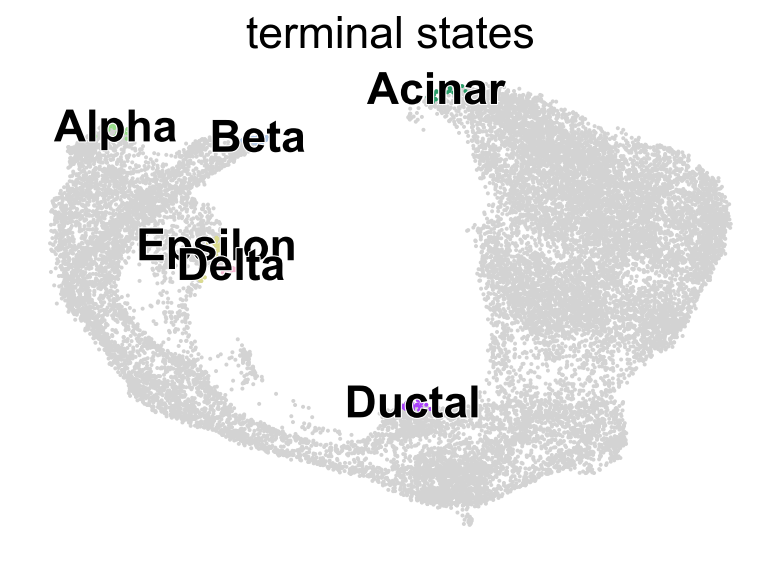

In [13]:
g.compute_terminal_states(method="top_n", n_states=6)
g.plot_terminal_states()

DEBUG: Raising an exception if there are less than `6` cells.
Adding `adata.obs['terminal_states']`
       `adata.obs['terminal_states_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`
Computing absorption probabilities
DEBUG: Solving the linear system using `PETSc` solver `'gmres'` on `1` core(s) with ilu preconditioner and `tol=1e-12`


  0%|          | 0/6 [00:00<?, ?/s]

DEBUG: Calculating mean time to absorption to any absorbing state
DEBUG: Solving the linear system using `PETSc` solver `'gmres'` on `1` core(s) with ilu preconditioner and `tol=1e-12`


  0%|          | 0/1 [00:00<?, ?/s]

Adding `adata.obsm['to_terminal_states']`
       `adata.obsm['absorption_times_fwd']`
       `.absorption_probabilities`
       `.absorption_times`
    Finish (0:00:02)


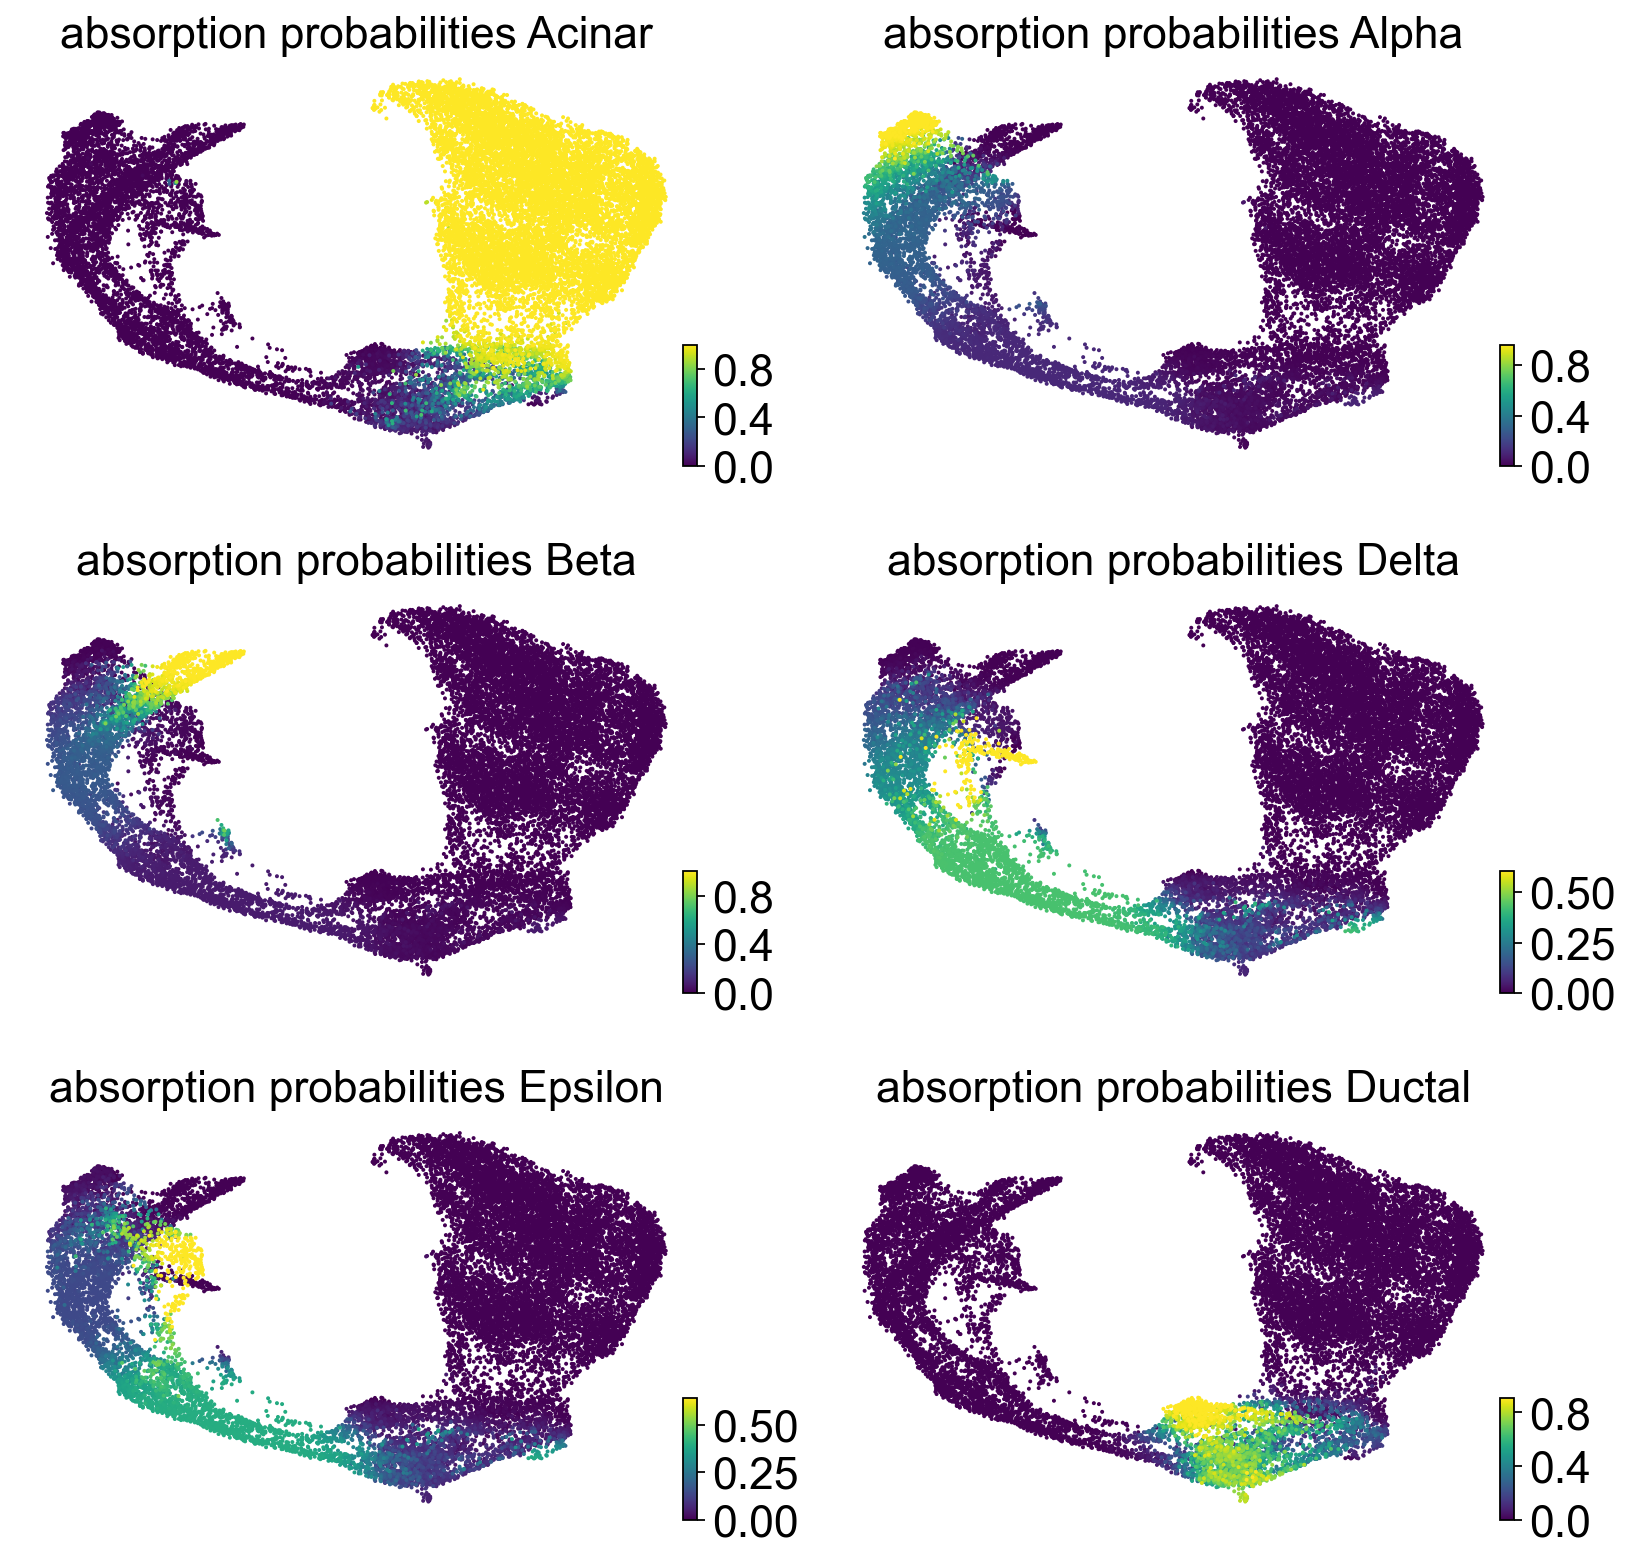

In [14]:
g.set_terminal_states_from_macrostates(
    [
        "Acinar", "Alpha", "Alpha","Alpha", "Beta", "Delta", "Epsilon", "Ductal"
    ]
)
g.compute_absorption_probabilities(solver="gmres", use_petsc=True, tol=1e-12, preconditioner='ilu', time_to_absorption='all')
g.plot_absorption_probabilities(same_plot=False, basis="umap", perc=[0, 99], ncols=2)

DEBUG: Plotting in mode `'heatmap'`


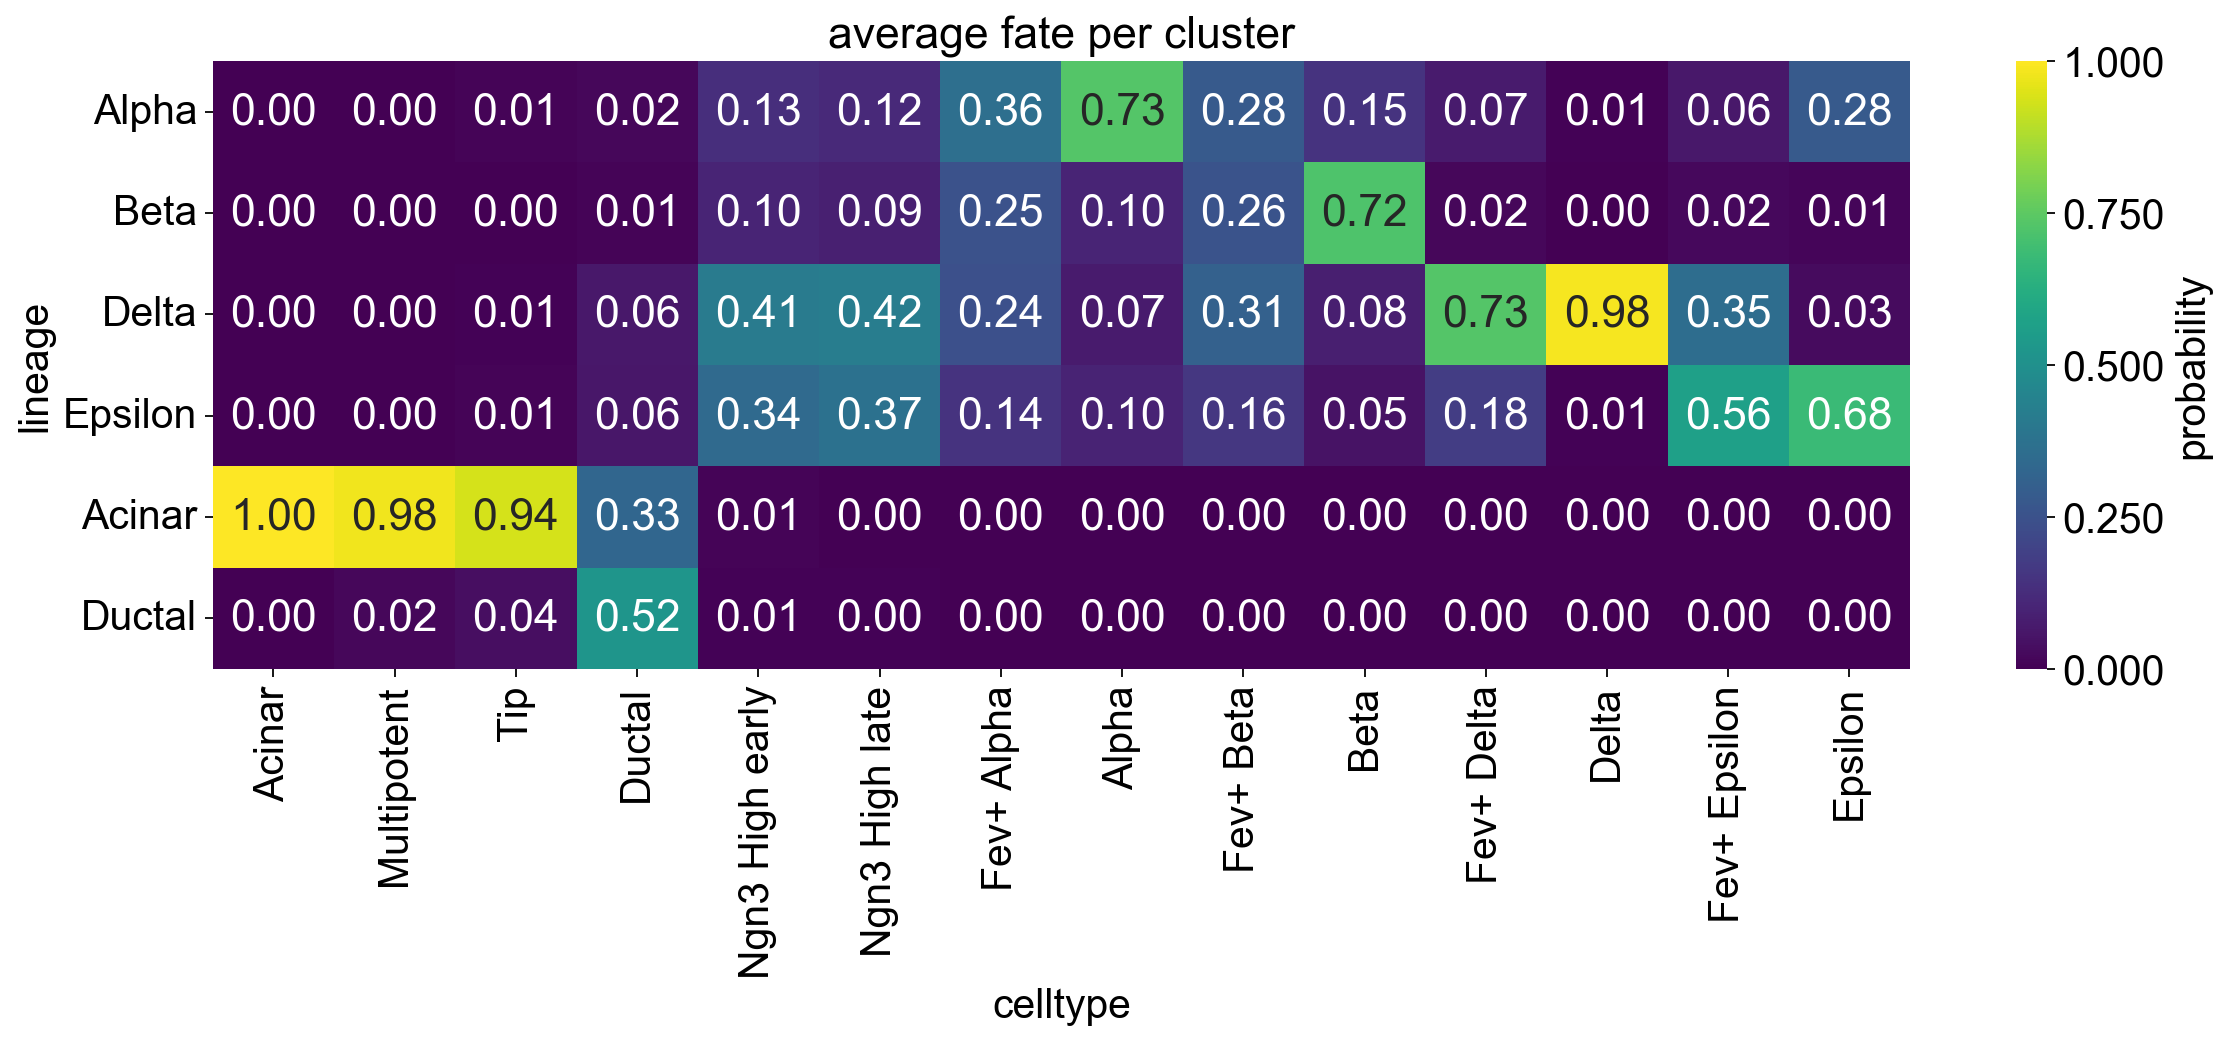

In [15]:
cr.pl.aggregate_absorption_probabilities(
    new_adata,
    mode='heatmap',
    lineages=["Alpha", "Beta", "Delta", "Epsilon", "Acinar", "Ductal"],
    cluster_key='celltype',
    clusters=['Acinar', 'Multipotent', 'Tip', 'Ductal', 'Ngn3 High early','Ngn3 High late', 'Fev+ Alpha', 'Alpha', 'Fev+ Beta', 'Beta', 'Fev+ Delta', 'Delta', 'Fev+ Epsilon', 'Epsilon'],
    figsize=(17, 5)
)